# Taxi Fare Prediction

## Import Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease, mean_loss_decrease

## Import Data

In [2]:
df = pd.read_csv("data/taxi_fare.csv", parse_dates=['pickup_datetime'])
df.dropna(inplace=True)

pickup_dt = df.pickup_datetime.dt
df['year'] = pickup_dt.year
df['month'] = pickup_dt.month
df['day'] = pickup_dt.dayofweek
df['hour'] = pickup_dt.hour
df.drop(columns='pickup_datetime', axis=1, inplace=True)

df['distance'] = np.abs(df.pickup_longitude - df.dropoff_longitude) + np.abs(df.pickup_latitude - df.dropoff_latitude) 
df.drop(columns=['pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis=1,
       inplace=True)

df.head()

,fare_amount,passenger_count,year,month,day,hour,distance
0,4.5,1.0,2009,6,0,17,0.011742
1,16.9,1.0,2010,1,1,16,0.107481
2,5.7,2.0,2011,8,3,0,0.019212
3,7.7,1.0,2012,4,5,4,0.029386
4,5.3,1.0,2010,3,1,7,0.027194


In [3]:
df.shape

(18918, 7)

## Dataset Splitting

In [4]:
X = df.drop(columns="fare_amount")
y = df.fare_amount

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((15134, 6), (3784, 6), (15134,), (3784,))

## Modelling

In [5]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp
from jcopml.tuning.space import Integer, Real

In [6]:
rsp.enet_poly_params

{'prep__numeric__poly__degree': Integer(low=1, high=3),
 'prep__numeric__poly__interaction_only': [True, False],
 'algo__fit_intercept': [True, False],
 'algo__alpha': Real(low=-4, high=2, prior='log-uniform'),
 'algo__l1_ratio': Real(low=0, high=1, prior='uniform')}

In [7]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform='yeo-johnson', scaling='standard'), ['passenger_count','year','distance']),
    ('categoric', cat_pipe(encoder='onehot'), ['month','day','hour']),
])


pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', ElasticNet())
])


model = RandomizedSearchCV(pipeline, rsp.enet_poly_params, cv=10, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   24.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.6min finished


{'algo__alpha': 0.0008632008168602546, 'algo__fit_intercept': True, 'algo__l1_ratio': 0.09997491581800291, 'prep__numeric__poly__degree': 3, 'prep__numeric__poly__interaction_only': False}
0.7193700257698614 0.7224749365528933 0.746097928933602


## Feature Important 

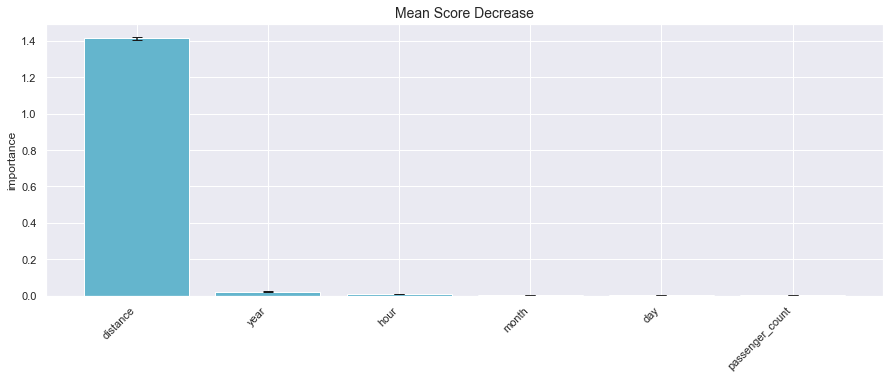

In [8]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True)

Distance merupakan fitur paling penting dalam memprediksi harga/biaya taksi.

## Evaluation 

In [9]:
from jcopml.plot import plot_residual

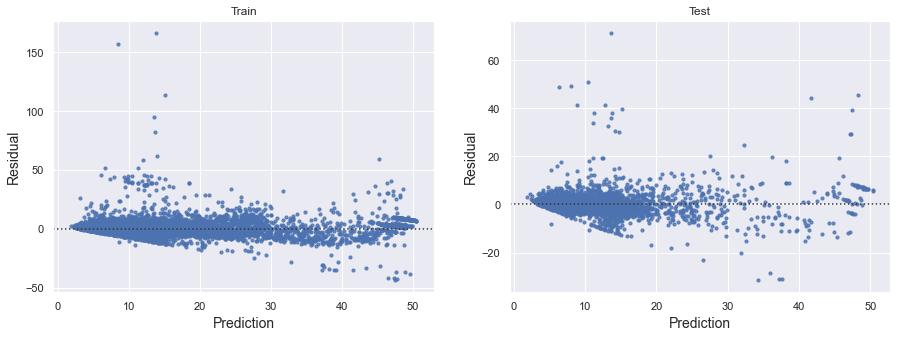

In [10]:
plot_residual(X_train, y_train, X_test, y_test, model)

Dari residual plot di atas saya melihat sepertinya terjadi kekurangan informasi.

## Coba cek datanya

In [11]:
df_analisis = X_train.copy()

pred = model.predict(X_train)
error = np.abs(pred - y_train)

df_analisis['fare'] = y_train
df_analisis['error'] = error
df_analisis.sort_values(by='error', ascending=False).head(10)

,passenger_count,year,month,day,hour,distance,fare,error
1335,1.0,2013,1,2,20,0.000000,180.00,166.123338
1483,1.0,2009,8,4,21,0.000416,165.00,156.500370
6630,1.0,2014,5,4,1,0.000000,128.83,113.739421
14142,1.0,2014,12,4,10,0.045860,108.00,94.422322
12915,1.0,2011,9,2,1,0.000000,96.00,82.252112
10524,1.0,2010,5,1,14,0.000000,75.80,61.844083
12349,1.0,2010,5,5,15,0.434492,104.67,59.390162
1494,1.0,2009,9,1,14,0.000031,70.00,57.921974
2432,1.0,2012,11,4,1,0.003817,58.60,51.939288
2346,1.0,2009,2,5,0,0.000000,63.00,51.605221


Bisa dilihat pada tabel di atas ada keanehan dimana distance 0 namun, biayanya ada. Dan data-data seperti itu memiliki error prediksi yang besar.

In [12]:
df[df.fare_amount <= 0]

,fare_amount,passenger_count,year,month,day,hour,distance
2039,-2.9,1.0,2010,3,1,23,0.002331
2486,-2.5,1.0,2015,3,6,5,0.000313
10002,0.0,1.0,2010,2,0,14,0.043644
13032,-3.0,4.0,2013,8,4,8,0.001425


Hal aneh lainnya adalah ada orang yang fare_amount - dan 0. Saya tidak tahu apakah - artinya berhutang dan 0 artinya dibayarkan oleh orang lain.? Untuk saat ini saya beranggapan data-data tersebut salah tulis. 